# Figure 6 – Comparative analysis of prime editing and cDNA screening datasets of TP53 variants reveals novel pathogenic variants in the oligomerization domain
## Figure 6a

Scatter-plot of prime editing Z-score for pegRNAs ≥ 10% editing at Day 34 in the Nutlin-treated condition, and the corresponding cDNA variant Z-score in the p53-WT background in the presence of Nutlin, colored by p53 domain.

Source data for comparison from here: https://www.nature.com/articles/s41588-018-0204-y

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os
#import re
import scipy.stats
import regex as re
from adjustText import adjust_text
import matplotlib.patheffects as PathEffects
from mpl_toolkits.axes_grid1 import make_axes_locatable
import statannot
plt.rc('font', family='Helvetica')

In [2]:
#loading in info about LFC, correct editing percentage and pegRNAs
#reading the MAGeCK results into a dictionary
#and also reading in information about correct editing percentage

#loading in the data
p53_filtered = pd.read_csv('p53_PE_sensor_FINAL_clean.csv')


#loading in the merged replicates to boost confidence on sensor
fp = "crispresso_replicates_merged"
reorder = []
conditions = ['D4', 'D16', 'D16-NUT', 'D25', 'D25-NUT', 'D34', 'D34-NUT']
for i in conditions:
    df = pd.read_csv(f"{fp}/{i}_reps_combined.csv")
    df['peg_id'] = p53_filtered['peg_id']
    reorder.append(df)

cp_dict2 = dict(zip(conditions, reorder))
samps = list(cp_dict2.keys())[1:]


#reading in mageck
fp = './MAGeCK analysis'
files = os.listdir(fp)
files = sorted([f for f in files if f[-3:]=='txt'])

dfs = []
for i,f in enumerate(files):
    df = pd.read_csv(fp + '/' + f, sep='\t')

    #ensure naming is correct
    assert f[:3]==samps[i][:3]

    #reorder the pegs...
    df = df.rename(columns = {'sgrna':'peg_id'})
    df_merge = pd.merge(p53_filtered, df, how='left', on='peg_id')

    #also add in merge of cp_dict?

    dfs.append(df_merge)


#perform thresholding of control_mean counts (filtering out pegRNAs with below 10 control counts mean)
#differences in counts because of normalization
#going to do it for one and apply it to all...

control_mean_threshold = 10

#d16
dd = dfs[0]
dd = dd[dd['control_mean']>=control_mean_threshold]
pegs_above_thres = dd['peg_id']

dfs2 = []
for i in dfs:
    dfs2.append(i[i['peg_id'].isin(pegs_above_thres)])


assert list(dfs2[0]['peg_id']) == list(dfs2[1]['peg_id']) 
assert list(dfs2[0]['peg_id']) == list(dfs2[2]['peg_id']) 
assert list(dfs2[0]['peg_id']) == list(dfs2[3]['peg_id']) 
assert list(dfs2[0]['peg_id']) == list(dfs2[4]['peg_id']) 
assert list(dfs2[0]['peg_id']) == list(dfs2[5]['peg_id']) 

mageck_dict = dict(zip(samps, dfs2))


In [3]:
sample = 'D34-NUT'
counts_threshold=10 #minimum of 10 sensor counts

bb = mageck_dict[sample].copy()
d34 = cp_dict2[sample]
p = d34[d34['Reads_aligned_all_amplicons']>=counts_threshold]

merged = pd.merge(bb, p, on='peg_id')

#filter to only include SNPs and ONPs
merged = merged[merged['variant_type'].isin(['SNV', 'ONV'])]


b = pd.read_excel('existing_p53_variant_annotations/41588_2018_204_MOESM6_ESM.xlsx', header=1) #z-scores

b = b.rename(columns={'Allele':'HGVSp'})

#and now change the Terminating variants to the correct format
hg = []
for k in list(b['HGVSp']):
    if 'Z' in k:
        k_new = k[:-1] + 'Ter'
    else:
        k_new = k

    hg.append(k_new)

b['HGVSp']=hg

merged2 = pd.merge(merged, b, on='HGVSp').reset_index()



In [4]:
#calculating z-scores for standardization of comparison

avg = np.average(merged2['LFC'])

std = np.std(merged2['LFC'])

z_scores = (merged2['LFC']-avg)/std

merged2['z_scores'] = z_scores
merged2

,index,peg_id,variant_index,HGVSp,HGVSc,gene,chr,start,end,variant_type,...,Signature_27,Signature_28,Signature_29,Signature_30,IARC_Mutation_Counts,GENIE_Mutation_Counts,Phenotypic_Selection_Model,Mutational_Signatures_Model,Combined_Model,z_scores
0,0,peg_2,0,R175H,c.524G>A,TP53,chr17,7578406,7578406,SNV,...,0.009368,0.002189,0.019684,0.015739,1221,382,12.340574,126.456961,939.020190,-0.799938
1,1,peg_3,0,R175H,c.524G>A,TP53,chr17,7578406,7578406,SNV,...,0.009368,0.002189,0.019684,0.015739,1221,382,12.340574,126.456961,939.020190,-0.080875
2,2,peg_4,0,R175H,c.524G>A,TP53,chr17,7578406,7578406,SNV,...,0.009368,0.002189,0.019684,0.015739,1221,382,12.340574,126.456961,939.020190,-1.053764
3,3,peg_5,0,R175H,c.524G>A,TP53,chr17,7578406,7578406,SNV,...,0.009368,0.002189,0.019684,0.015739,1221,382,12.340574,126.456961,939.020190,-0.983323
4,4,peg_6,0,R175H,c.524G>A,TP53,chr17,7578406,7578406,SNV,...,0.009368,0.002189,0.019684,0.015739,1221,382,12.340574,126.456961,939.020190,-1.203554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13389,13389,peg_20260,874,V97F,c.289G>T,TP53,chr17,7579398,7579398,SNV,...,0.005206,0.001397,0.069982,0.000000,1,0,1.878838,7.423729,3.333116,0.952459
13390,13390,peg_20261,874,V97F,c.289G>T,TP53,chr17,7579398,7579398,SNV,...,0.005206,0.001397,0.069982,0.000000,1,0,1.878838,7.423729,3.333116,1.138072
13391,13391,peg_20262,874,V97F,c.289G>T,TP53,chr17,7579398,7579398,SNV,...,0.005206,0.001397,0.069982,0.000000,1,0,1.878838,7.423729,3.333116,2.004126
13392,13392,peg_20263,874,V97F,c.289G>T,TP53,chr17,7579398,7579398,SNV,...,0.005206,0.001397,0.069982,0.000000,1,0,1.878838,7.423729,3.333116,1.695874


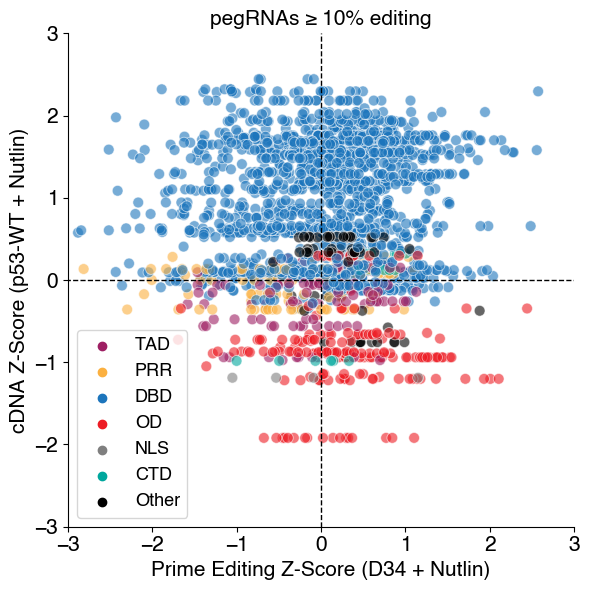

In [5]:
m11 = merged2.copy()
wt_nut = 'A549_p53WT_Nutlin-3_Z-score'

corr_perc_min = 10
corr_perc_max = 100
m11 = m11[(m11['corr_perc_backsub']>=corr_perc_min) & (m11['corr_perc_backsub']<=corr_perc_max)]

fig, ax = plt.subplots(figsize=(6,6))

colors= ['#9E1F63', '#FBB040', '#1C75BC', '#ED1C24', 'tab:grey', '#00A79D', 'black']


order = ['TAD', 'PRR', 'DBD', 'OD', 'NLS', 'CTD', 'Other']

sns.scatterplot(data=m11, x='z_scores', y=wt_nut, hue='Domain',ax=ax, palette=colors, hue_order=order, s=60, alpha=.6)#edgecolor='black', linewidth=.2, alpha=.7)
ax.plot([-5,5], [0,0], linestyle='dashed',color='black', linewidth=1)
#ax.plot([0,0], [-2.5,2.5], linestyle='dashed',color='black', linewidth=1)

cutoff = 1.5
x_bins = np.linspace(-5,5,20)
y1 = .5*x_bins-cutoff
y2 = .5*x_bins+cutoff
#ax.plot(x_bins,y1, linestyle='dashed',color='black', linewidth=1)

#ax.plot(x_bins,y2, linestyle='dashed',color='black', linewidth=1)
ax.plot([0,0],[-3, 3],linestyle='dashed',color='black', linewidth=1)


ax.set_ylim(-3,3)
ax.set_xlim(-3,3)


ax.set_xlabel('Prime Editing Z-Score (D34 + Nutlin)', fontsize=15)
ax.set_ylabel('cDNA Z-Score (p53-WT + Nutlin)', fontsize=15)
ax.set_title(f"pegRNAs ≥ {corr_perc_min}% editing", fontsize=15)
#ax.legend(bbox_to_anchor=(1.05, .5), fontsize=14
#          )
ax.legend(fontsize=13, loc='lower left')

ax.tick_params(axis='both', which='major', labelsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()

## Figure 6b
cDNA (red) and prime editing (blue) Z-scores for pegRNAs/variants located in the oligomerization domain. The pegRNA with the highest Z-score is labeled.

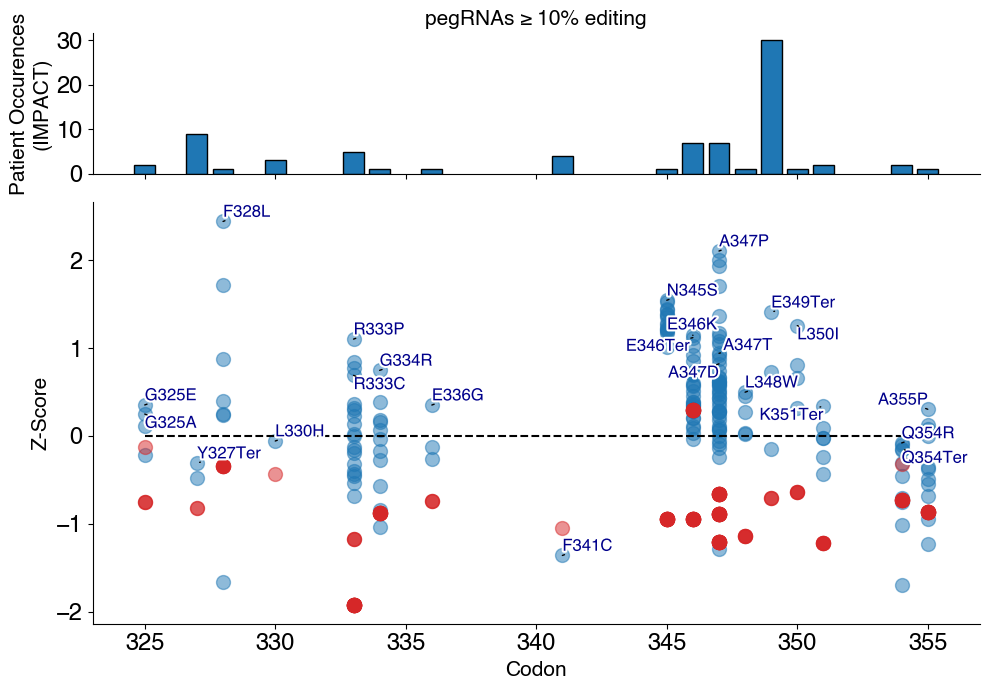

In [6]:
m11 = merged2.copy()

corr_perc_min = 10
corr_perc_max = 100

m11 = m11[(m11['corr_perc_backsub']>=corr_perc_min) & (m11['corr_perc_backsub']<=corr_perc_max)]

od = m11.copy()
od = od[od['Domain']=='OD']
od = od.reset_index()

#patient occurrences
uniq_vars, counts = np.unique(od['HGVSp'], return_counts=True)
uniq_vars = list(uniq_vars)

cods = []
noccur = []
for i in uniq_vars:
    sub = m11[m11['HGVSp']==i].reset_index()
    cod = sub.iloc[0]['codon']
    no = sub.iloc[0]['num_occurences']
    cods.append(cod)
    noccur.append(no)

u_cods = list(np.unique(cods))
u_cod_count = np.zeros(len(u_cods))

for i, val in enumerate(cods):
    idx = u_cods.index(val)
    u_cod_count[idx]+=noccur[i]

#-------and plotting----------

fig, ax = plt.subplots(2,1,figsize=(10,7), sharex=True, height_ratios=[1,3])

ax[0].bar(u_cods, u_cod_count, linewidth=1, edgecolor='black')

ax[1].scatter(od['codon'], od['z_scores'], c='tab:blue', alpha=.5, label='Prime Editing', s=100)
ax[1].scatter(od['codon'], od[wt_nut], c='tab:red', alpha=.5, label='cDNA', s=100)

ax[1].plot([325,355], [0,0], linestyle='dashed',color='black' )

ax[1].set_xlim(323,357)

#ax[1].legend(fontsize=15, bbox_to_anchor=(1.05, .75))
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[0].tick_params(axis='both', which='major', labelsize=17)
ax[1].tick_params(axis='both', which='major', labelsize=17)
ax[1].set_xlabel('Codon', fontsize=15)
ax[0].set_ylabel('Patient Occurences\n(IMPACT)', fontsize=15)
ax[1].set_ylabel('Z-Score', fontsize=15)
ax[0].set_title(f'pegRNAs ≥ {corr_perc_min}% editing', fontsize=15)
#ax[1].legend(bbox_to_anchor=(1.05, .75), fontsize=14
ax[0].set_yticks([0,10,20,30])

uniq_vars, counts = np.unique(od['HGVSp'], return_counts=True)

i_maxs = []
for idx in uniq_vars:
    sub = od[od['HGVSp']==idx]
    i_max = sub['z_scores'].idxmax()
    i_maxs.append(i_max)
    
od_top_vars = od.iloc[i_maxs]
t = list(od_top_vars['HGVSp'])
x=list(od_top_vars['codon'])
y = list(od_top_vars['z_scores'])


texts = [ax[1].text(x[i], y[i], t[i], fontsize=12, color='darkblue', path_effects=[PathEffects.withStroke(linewidth=3,
                                                                                  foreground="w")]) for i in range(len(x))] #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = .9)


adjust_text(texts,only_move={'points':'y', 'texts':'xy'},
            arrowprops=dict(arrowstyle="-", linewidth=1, alpha=1, color='black'))

fig.tight_layout()

## Figure 6c, d

The difference in Z-scores between prime editing and cDNA screens (∆Z-score) for pegRNAs ≥ 10% and ≥ 30% editing, separated by p53 domain. Statistics shown for t-test of independent samples with Bonferroni correction. * = p-value ≤ .05, ** = p-value ≤ .01, *** = p-value ≤ .001, **** = p-value ≤ .0001, ns = not significant (p-value > .05).

In [7]:
#first calcualting the delta z-score
m11 = merged2.copy()
wt_nut = 'A549_p53WT_Nutlin-3_Z-score'
m11['delta'] = m11['LFC'] - m11[wt_nut]

corr_perc_min = 10
corr_perc_max = 100
m11 = m11[(m11['corr_perc_backsub']>=corr_perc_min) & (m11['corr_perc_backsub']<=corr_perc_max)]


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

DBD v.s. OD: t-test independent samples with Bonferroni correction, P_val=6.025e-85 stat=-2.071e+01
PRR v.s. OD: t-test independent samples with Bonferroni correction, P_val=1.396e-26 stat=-1.200e+01
TAD v.s. OD: t-test independent samples with Bonferroni correction, P_val=3.684e-15 stat=-8.495e+00


/var/folders/5g/xxjcy2g531n02hnyb6d8qdsr0000gn/T/ipykernel_26119/456634244.py:9: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=m11, x='Domain', y='delta', order=order,ax=ax, palette=colors, alpha=.3)


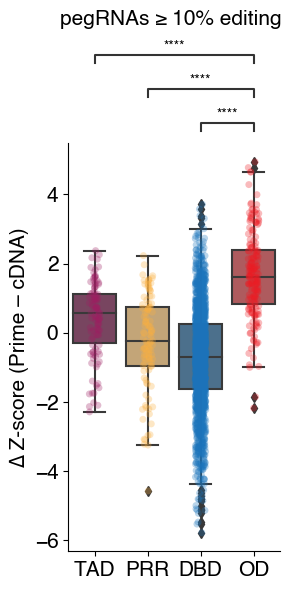

In [8]:
#then plotting 
colors= ['#9E1F63', '#FBB040', '#1C75BC', '#ED1C24']

fig, ax = plt.subplots(figsize=(3,6))

order = ['TAD', 'PRR', 'DBD', 'OD']

sns.boxplot(data=m11, x='Domain', y='delta', order=order,ax=ax, saturation=.4, palette=colors)
sns.stripplot(data=m11, x='Domain', y='delta', order=order,ax=ax, palette=colors, alpha=.3)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

import statannot
statannot.add_stat_annotation(
    ax,
    data=m11,
    x='Domain',
    y='delta',
    order=order,
    #hue=hue,
    box_pairs=[
        (("OD"), ("TAD")),
        (("OD"), ("PRR")),
        (("OD"), ("DBD"))
    ],
    test="t-test_ind",
    text_format="star",
    loc="outside",
)
ax.set_ylabel('∆ Z-score (Prime – cDNA)', fontsize=15)
ax.set_xlabel('')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_title(f'pegRNAs ≥ {corr_perc_min}% editing \n\n\n\n\n', fontsize=15)
fig.tight_layout()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

DBD v.s. OD: t-test independent samples with Bonferroni correction, P_val=3.255e-50 stat=-1.610e+01
PRR v.s. OD: t-test independent samples with Bonferroni correction, P_val=3.158e-17 stat=-9.701e+00
TAD v.s. OD: t-test independent samples with Bonferroni correction, P_val=2.085e-11 stat=-7.456e+00


/var/folders/5g/xxjcy2g531n02hnyb6d8qdsr0000gn/T/ipykernel_22740/2735585198.py:16: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=m11, x='Domain', y='delta', order=order,ax=ax, palette=colors, alpha=.3)
/var/folders/5g/xxjcy2g531n02hnyb6d8qdsr0000gn/T/ipykernel_22740/2735585198.py:16: UserWarning: The palette list has more values (7) than needed (4), which may not be intended.
  sns.stripplot(data=m11, x='Domain', y='delta', order=order,ax=ax, palette=colors, alpha=.3)


Text(0.5, 1.0, 'pegRNAs ≥ 30% editing \n\n\n\n\n\n')

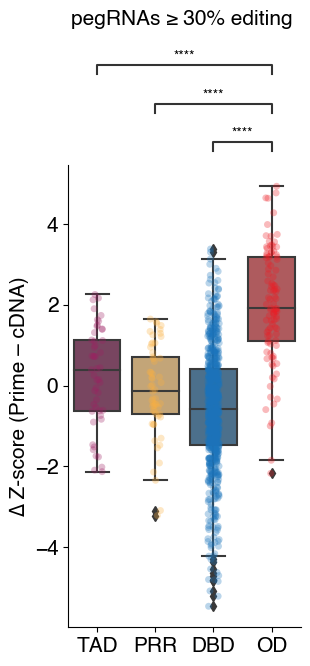

In [19]:
#now redoing for 30% minimum editing
#first calcualting the delta z-score
m11 = merged2.copy()
wt_nut = 'A549_p53WT_Nutlin-3_Z-score'
m11['delta'] = m11['LFC'] - m11[wt_nut]

corr_perc_min = 30
corr_perc_max = 100
m11 = m11[(m11['corr_perc_backsub']>=corr_perc_min) & (m11['corr_perc_backsub']<=corr_perc_max)]

fig, ax = plt.subplots(figsize=(3,6))

order = ['TAD', 'PRR', 'DBD', 'OD']

sns.boxplot(data=m11, x='Domain', y='delta', order=order,ax=ax, saturation=.4, palette=colors)
sns.stripplot(data=m11, x='Domain', y='delta', order=order,ax=ax, palette=colors, alpha=.3)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

import statannot
statannot.add_stat_annotation(
    ax,
    data=m11,
    x='Domain',
    y='delta',
    order=order,
    #hue=hue,
    box_pairs=[
        (("OD"), ("TAD")),
        (("OD"), ("PRR")),
        (("OD"), ("DBD"))
    ],
    test="t-test_ind",
    text_format="star",
    loc="outside",
)
ax.set_ylabel('∆ Z-score (Prime – cDNA)', fontsize=15)
ax.set_xlabel('')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_title(f'pegRNAs ≥ {corr_perc_min}% editing \n\n\n\n\n\n', fontsize=15)


## Figure 6e

Z-scores for variants in the cDNA (red) and prime editing (blue) screens, considering only the most efficient pegRNA for each variant with an editing efficiency ≥ 10%.

In [9]:
#looking at top efficient pegRNAs
uniq_vars, counts = np.unique(od['HGVSp'], return_counts=True)


m11 = merged2.copy()
#m11['delta_'] = m11['LFC'] - m11['A549_p53NULL_Nutlin-3_Z-score']

corr_perc_min = 10
corr_perc_max = 100
m11 = m11[(m11['corr_perc_backsub']>=corr_perc_min) & (m11['corr_perc_backsub']<=corr_perc_max)]

od = m11[m11['Domain']=='OD']

od = od.reset_index()

i_maxs = []
for idx in uniq_vars:
    sub = od[od['HGVSp']==idx]
    i_max = sub['corr_perc_backsub'].idxmax()
    i_maxs.append(i_max)
    

od_top_vars = od.iloc[i_maxs]

od2 = od_top_vars.copy()
od2 = od2.drop(columns='z_scores')
od2 = od2.rename(columns={wt_nut:'z_scores'})
od2['Screen']='cDNA'

od_top_vars['Screen'] = 'Prime Editing'

stacked = pd.concat((od_top_vars, od2))

/var/folders/5g/xxjcy2g531n02hnyb6d8qdsr0000gn/T/ipykernel_26119/2593632920.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  od_top_vars['Screen'] = 'Prime Editing'


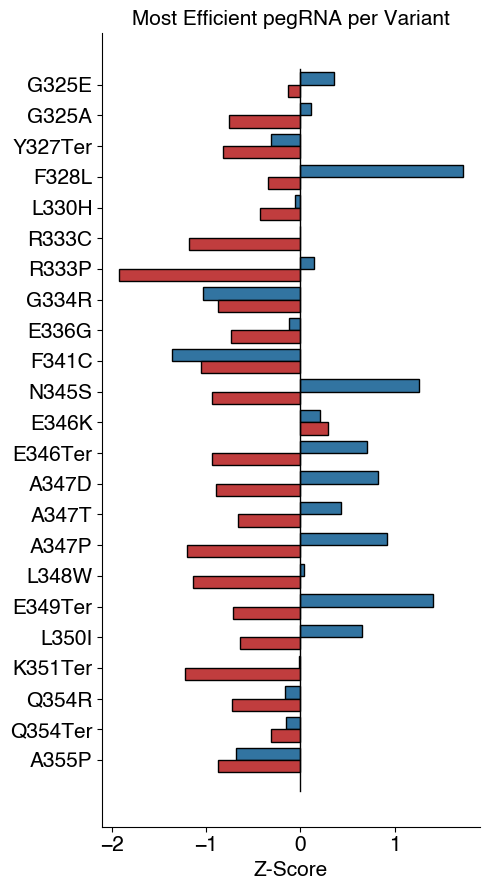

In [10]:
u = np.unique(stacked['HGVSp'])
id = [i[1:4] for i in u]
out = pd.DataFrame(dict(zip(['u','i'], [u,id]))).sort_values(by='i', ascending=True)
order = list(out['u'])

fig, ax = plt.subplots(figsize=(5,9))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)

sns.barplot(data = stacked, y='HGVSp', x='z_scores', hue='Screen', order=order, palette=['tab:blue', 'tab:red'], linewidth=1, edgecolor='black')
ax.plot([0,0],[-.50, len(order)], linewidth=1, color='black')
ax.legend_.remove()

ax.set_ylabel('')
ax.set_xlabel('Z-Score', fontsize=15)
ax.set_title('Most Efficient pegRNA per Variant', fontsize=15)

plt.xticks(rotation=0)

fig.tight_layout()

## Figure 6f

Box-plot of the z-scores for variants in the cDNA (red) and prime editing (blue) screens, considering only the most efficient pegRNA for each variant. Statistics shown for t-test of independent samples with Bonferroni correction; **** = p-value ≤ .0001.

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Prime Editing v.s. cDNA: t-test independent samples with Bonferroni correction, P_val=1.192e-06 stat=5.626e+00


/var/folders/5g/xxjcy2g531n02hnyb6d8qdsr0000gn/T/ipykernel_26119/3918178740.py:10: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data = stacked, x='Screen', y='z_scores', palette=['tab:blue', 'tab:red'], alpha=.5)


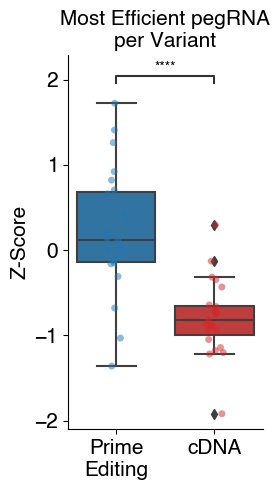

In [11]:
#and a box plot comparison

fig, ax = plt.subplots(figsize=(3,5))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)

sns.boxplot(data = stacked, x='Screen', y='z_scores', palette=['tab:blue', 'tab:red'])
sns.stripplot(data = stacked, x='Screen', y='z_scores', palette=['tab:blue', 'tab:red'], alpha=.5)

ax.set_xticklabels(['Prime\nEditing', 'cDNA'])
ax.set_xlabel('')
ax.set_ylabel('Z-Score', fontsize=15)
ax.set_title('Most Efficient pegRNA\nper Variant', fontsize=15)

import statannot
statannot.add_stat_annotation(
    ax,
    data=stacked,
    x='Screen',
    y='z_scores',
    #hue=hue,
    box_pairs=[
        (("Prime Editing"), ("cDNA")),
    ],
    test="t-test_ind",
    text_format="star",
    loc="inside",
)

fig.tight_layout()

## Figure 6g

Visualization of the residue-averaged ∆Z-scores (pegRNAs ≥ 10% editing) on an NMR-structure of p53 oligomerization domain (PDB: 1OLG).

Code here shown for generating residue-averaged ∆Z-Scores. Visualization performed in pymol by substituting the b-factors with these values and then visualizing as heatmap. For more info see: https://pymolwiki.org/index.php/Load_new_B-factors


In [25]:
m11 = merged2.copy()
m11['delta'] = m11['LFC'] - m11['A549_p53WT_Nutlin-3_Z-score']

corr_perc_min = 10
corr_perc_max = 100
m11 = m11[(m11['corr_perc_backsub']>=corr_perc_min) & (m11['corr_perc_backsub']<=corr_perc_max)]

sort1 = m11[(m11['codon']>=319) &(m11['codon']<=360)].sort_values(by='codon').reset_index()

codon_locs = list(range(319,361))
holder = np.zeros(len(codon_locs))
delta_df = pd.DataFrame((dict(zip(['codon', 'average_delta'], [codon_locs, holder])))).set_index('codon')

#exclude terminating variants????

#average on codon
for i in np.unique(sort1['codon']):
    sub = sort1[sort1['codon']==i]
    avg1 = np.average(sub['delta'])

    delta_df.loc[int(i), 'average_delta'] = avg1

In [26]:
delta_df

,average_delta
codon,
319,0.000000
320,0.000000
321,0.000000
322,1.814672
323,0.000000
324,2.132768
325,1.046287
326,0.000000
327,0.398751


# Competition Assay & cDNA data

Update figure accordingly when data comes in.

In [430]:
fp1 = 'competition_asay_data_FULL'

#read the plate set up into a dictionary
l1 = os.listdir(fp1)
l1 = sorted([i for i in l1 if i[-3:]=='csv'])

df_holder = []
for i in l1:
    a = pd.read_csv(f'{fp1}/{i}')
    df_holder.append(a)

key_dict = dict(zip(l1, df_holder))

In [431]:
#then read in the compeition assay flow data
#processed with FlowJo

fp2 = 'competition_asay_data_FULL/processed_data'
l2 = os.listdir(fp2)
l2 = sorted([i for i in l2 if i[-3:]=='csv'])

#and match up plate set up with correct files
#make a joint table for matching things up

matching = [None,
'A549-PEmax-p53ODmuts-WellplateSetup-plate1.csv',
'A549-PEmax-p53ODmuts-WellplateSetup-plate2.csv',
'A549-PEmax-p53ODmuts-WellplateSetup-plate1.csv',
 'A549-PEmax-p53ODmuts-WellplateSetup-plate2.csv',
 'A549-PEmax-p53ODmuts-WellplateSetup-plate1.csv',
 'A549-PEmax-p53ODmuts-WellplateSetup-plate2.csv',
 None,
 'A549-PEmax-pegRNAvalidation-REDO-WellplateSetup-plate1.csv',
 'A549-PEmax-pegRNAvalidation-REDO-WellplateSetup-plate2.csv',
 'A549-PEmax-pegRNAvalidation-REDO-WellplateSetup-plate1.csv',
 'A549-PEmax-pegRNAvalidation-REDO-WellplateSetup-plate2.csv',
]

match_df = pd.DataFrame(dict(zip(['file', 'template'], [l2, matching])))
match_df

,file,template
0,A549-ODmuts-T0.csv,None
1,A549-PEmax-ODmuts-T1-plate1.csv,A549-PEmax-p53ODmuts-WellplateSetup-plate1.csv
2,A549-PEmax-ODmuts-T1-plate2.csv,A549-PEmax-p53ODmuts-WellplateSetup-plate2.csv
3,A549-PEmax-ODmuts-T2-plate1.csv,A549-PEmax-p53ODmuts-WellplateSetup-plate1.csv
4,A549-PEmax-ODmuts-T2-plate2.csv,A549-PEmax-p53ODmuts-WellplateSetup-plate2.csv
5,A549-PEmax-ODmuts-T3-plate1.csv,A549-PEmax-p53ODmuts-WellplateSetup-plate1.csv
6,A549-PEmax-ODmuts-T3-plate2.csv,A549-PEmax-p53ODmuts-WellplateSetup-plate2.csv
7,A549-PEmax-T0.csv,None
8,A549-PEmax-T1-plate1.csv,A549-PEmax-pegRNAvalidation-REDO-WellplateSetu...
9,A549-PEmax-T1-plate2.csv,A549-PEmax-pegRNAvalidation-REDO-WellplateSetu...


In [433]:
def read_samples(t0_df, match_df):
    """ 
    Function for reading in competition assay samples
    """

    col_dict = {'singlets/singlets2/singlets3 | Count': 'cell_count', 'singlets/singlets2/singlets3/RFP+ | Freq. of Parent (%)': 'RFP+ %'}
    dh = []

    for i, val in match_df.iterrows():
        f = val['file']
        t = val['template']
        #if t!=None:

        time = int(f.split('-')[-2][-1])
        

        aa = pd.read_csv(f'{fp2}/{f}')
        ident = []
        for i in aa['Unnamed: 0']:
            if '.fcs' in i:
                id = i.split('_')[-2]
                ident.append(id)

        aa = aa[:-2] #get rid of mean and SD files
        aa['Well'] = ident
        
        t_df = key_dict[t]

        m1 = pd.merge(aa, t_df, on='Well', how='left')
        
        m1['Timepoint'] = time

        m1 = m1.rename(columns = col_dict)
        dh.append(m1)

    #concatenate timepoints  
    concat_df = pd.concat(dh)

    #and finally add in T0 timepoint data...
    #aa = pd.read_csv(f'{fp2}/{l2[7]}')
    aa = t0_df
    aa = aa.rename(columns = {'Unnamed: 0':'pegRNA Identity'})
    aa = aa.rename(columns = col_dict)

    aa = aa[:-2]
    aa['pegRNA Identity'] = [i[:-4] for i in aa['pegRNA Identity']]
    aa['Timepoint'] = 0
    aa.loc[[0], 'pegRNA Identity'] = 'CONTROL'
    aa['Treatment'] = 'Untreated'
    aa2 = aa.copy()
    aa2['Treatment'] = 'Treated'


    #final concat
    concat_a549 = pd.concat([concat_df, aa, aa, aa, aa2, aa2, aa2])

    #and fix sample names
    #concat_a549['pegRNA Identity'] = [i.upper() for i in concat_a549['pegRNA Identity']]


    concat_a549['Treatment'] = concat_a549['Treatment'].fillna('Untreated')
    concat_a549 = concat_a549.reset_index()

    return concat_a549

def event_correction(concat_a549_OD, timepoint_final=2, event_threshold=500):
    """ 
    Function for correction of RFP% when below a certain event threshold;
    If sample is below threshold, this function transforms the dataframe so that 
    the RFP% is equal to that at the previous timepoint
    """
    #event_threshold = 500

    if timepoint_final==2:
        t0 = concat_a549_OD[concat_a549_OD['Timepoint']==0]
        t1 = concat_a549_OD[concat_a549_OD['Timepoint']==1]
        t2 = concat_a549_OD[concat_a549_OD['Timepoint']==2]
        lh = [t1, t2]
        #t3 = concat_a549_OD[concat_a549_OD['Timepoint']==3]
    elif timepoint_final==3:
        t0 = concat_a549_OD[concat_a549_OD['Timepoint']==0]
        t1 = concat_a549_OD[concat_a549_OD['Timepoint']==1]
        t2 = concat_a549_OD[concat_a549_OD['Timepoint']==2]
        t3 = concat_a549_OD[concat_a549_OD['Timepoint']==3]
        lh = [t1,t2,t3]
    else:
        assert 1==0, print('CORRECT THE FUNCTION TO ACCOUNT FOR DIFFERENT NUMBER OF TIME-POINTS')

    corrected_df = concat_a549_OD.copy()
    corrected_df['Corrected']=False

    #new_dfs = [t0]
    for t, val1 in enumerate(lh):
        x = val1
        x_copy = x.copy()
        timepoint_prev = t
        for i, val in x.iterrows():

            if val['cell_count']< event_threshold:

                v = val['pegRNA Identity']
                r = val['Replicate']
                tr = val['Treatment']

                t_previous = corrected_df[corrected_df['Timepoint']==timepoint_prev]

                if timepoint_prev >0:
                    kk =t_previous[(t_previous['pegRNA Identity']==v)&(t_previous['Replicate']==r)&(t_previous['Treatment']==tr)]['RFP+ %'].values[0]
                elif timepoint_prev==0:
                    kk =t_previous[(t_previous['pegRNA Identity']==v)]['RFP+ %'].values[0]
                
                assert str(x_copy.loc[i, 'pegRNA Identity'])==v, print(x_copy.loc[i, 'pegRNA Identity'])
                corrected_df.loc[i, 'RFP+ %'] = kk
                corrected_df.loc[i, 'Corrected'] = True
                
            else:
                continue

    return corrected_df

In [434]:
t0_df = pd.read_csv(f'{fp2}/{l2[0]}')
match_df2 = match_df[1:7]

a549 = read_samples(t0_df, match_df2)
a549['pegRNA Identity'] = [i.upper() for i in a549['pegRNA Identity']]
#a549 = a549[a549['pegRNA Identity']!='CONTROL']
a549 = event_correction(a549, timepoint_final=3, event_threshold=1000).drop(columns='index')

/Users/samgould/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/samgould/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/samgould/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/samgould/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

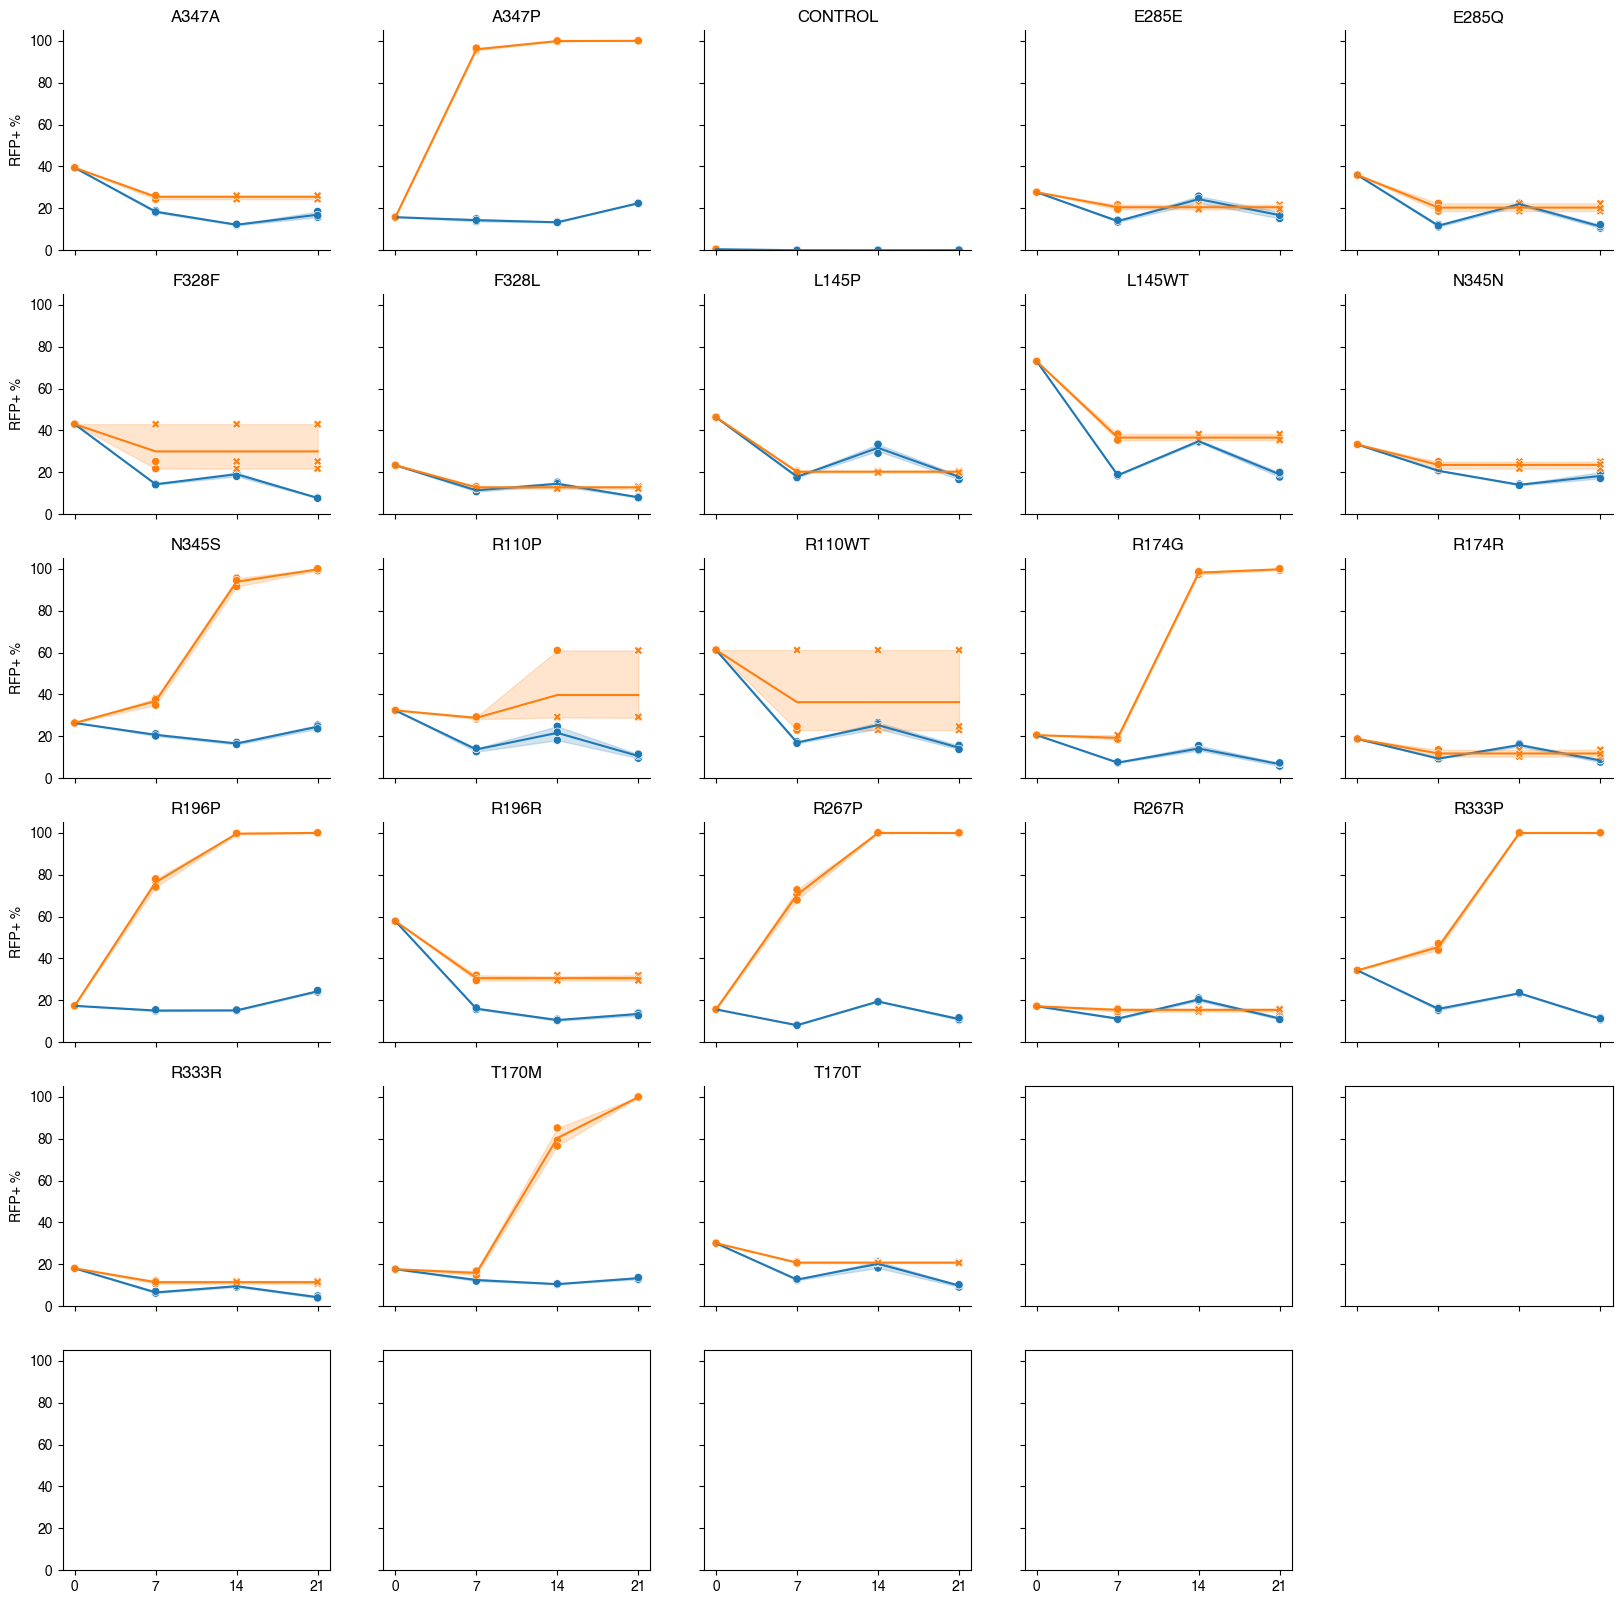

In [149]:
plot_df = a549

#and plotting
s1 = np.unique(plot_df['pegRNA Identity'])
samp_dict = dict(zip(list(range(1, len(s1)+1)), s1))

fig, ax = plt.subplots(6,5, figsize=(20,20), sharex=True, sharey=True)
for i in range(6):
    for k in range(5):
        row = i%6
        col = k
        sample_num = k +1+ i*5 
        if sample_num<=len(s1):
            sns.lineplot(data = plot_df[plot_df['pegRNA Identity']==samp_dict[sample_num]], x='Timepoint', y='RFP+ %', hue='Treatment', ax = ax[row][col], legend=False)
            sns.scatterplot(data = plot_df[plot_df['pegRNA Identity']==samp_dict[sample_num]], x='Timepoint', y='RFP+ %', hue='Treatment', style = 'Corrected', markers=['o', 'X'], ax = ax[row][col], legend=False)
            if sample_num<=29:
                tit = samp_dict[sample_num]
                ax[row][col].set_title(tit)
                ax[row][col].spines['top'].set_visible(False)
                ax[row][col].spines['right'].set_visible(False)
                
            else:
                continue
        else:
            continue

ax[0][0].set_xticks([0,1,2,3])
ax[0][0].set_xticklabels([0,7,14,21])
ax[0][0].set_ylim(0,105)
fig.delaxes(ax[5][4])

# cDNA data

In [435]:
fp1 = '/Users/samgould/Desktop/FSR Lab/Manuscripts/p53 PE sensor/Competition_assay_full_analysis/A549-PEmax-p53ODmuts-cDNA-CompAssay'

#read the plate set up into a dictionary

l1 = ['A549-PEmax-p53ODmuts-cDNA-WellplateSetup.csv']

df_holder = []
for i in l1:
    a = pd.read_csv(f'{fp1}/{i}')
    df_holder.append(a)

key_dict = dict(zip(l1, df_holder))

In [436]:
key_dict['A549-PEmax-p53ODmuts-cDNA-WellplateSetup.csv']

,Well,cDNA Identity,Treatment,Replicate
0,A1,CONTROL,NaN,NaN
1,A2,CONTROL,NaN,NaN
2,A3,CONTROL,NaN,NaN
3,A4,CONTROL,NaN,NaN
4,A5,CONTROL,NaN,NaN
...,...,...,...,...
91,H8,NaN,NaN,NaN
92,H9,NaN,NaN,NaN
93,H10,NaN,NaN,NaN
94,H11,NaN,NaN,NaN


In [437]:
l2 = [  'cDNA-day0-T0.csv',
 'cDNA_t1_day3-T1-plate.csv',
 'cDNA_t2_day7-T2-plate.csv']

matching = [None,
            'A549-PEmax-p53ODmuts-cDNA-WellplateSetup.csv',
            'A549-PEmax-p53ODmuts-cDNA-WellplateSetup.csv']

match_df_cdna = pd.DataFrame(dict(zip(['file', 'template'], [l2, matching])))
match_df_cdna

,file,template
0,cDNA-day0-T0.csv,None
1,cDNA_t1_day3-T1-plate.csv,A549-PEmax-p53ODmuts-cDNA-WellplateSetup.csv
2,cDNA_t2_day7-T2-plate.csv,A549-PEmax-p53ODmuts-cDNA-WellplateSetup.csv


In [438]:
def read_samples(t0_df, match_df):
    """ 
    Function for reading in competition assay samples
    """

    col_dict = {'singlets/singlets2/singlets3 | Count': 'cell_count', 'singlets/singlets2/singlets3/RFP+ | Freq. of Parent (%)': 'RFP+ %'}
    dh = []

    for i, val in match_df.iterrows():
        f = val['file']
        t = val['template']
        print(f)
        print(t)
        #if t!=None:
        time = int(f.split('-')[-2][-1])
        

        aa = pd.read_csv(f'{fp1}/{f}')
        ident = []
        for i in aa['Unnamed: 0']:
            if '.fcs' in i:
                id = i.split('_')[-2]
                ident.append(id)

        aa = aa[:-2] #get rid of mean and SD files
        aa['Well'] = ident
        
        t_df = key_dict[t]

        m1 = pd.merge(aa, t_df, on='Well', how='left')
        
        m1['Timepoint'] = time

        m1 = m1.rename(columns = col_dict)
        dh.append(m1)

    #concatenate timepoints  
    concat_df = pd.concat(dh)

    #and finally add in T0 timepoint data...
    #aa = pd.read_csv(f'{fp2}/{l2[7]}')
    aa = t0_df
    aa = aa.rename(columns = {'Unnamed: 0':'cDNA Identity'})
    aa = aa.rename(columns = col_dict)

    aa = aa[:-2]
    aa['cDNA Identity'] = [i[:-4] for i in aa['cDNA Identity']]
    aa['cDNA Identity'] = [i.split('-')[-1] for i in aa['cDNA Identity']]
    aa.loc[aa['cDNA Identity'] == 'PEmax', 'cDNA Identity'] = 'CONTROL'
    aa['Timepoint'] = 0
    #aa.loc[[0], 'pegRNA Identity'] = 'CONTROL'
    aa['Treatment'] = 'Untreated'
    aa2 = aa.copy()
    aa2['Treatment'] = 'Treated'


    #final concat
    concat_a549 = pd.concat([concat_df, aa, aa, aa, aa2, aa2, aa2])

    #and fix sample names
    #concat_a549['pegRNA Identity'] = [i.upper() for i in concat_a549['pegRNA Identity']]


    concat_a549['Treatment'] = concat_a549['Treatment'].fillna('Untreated')
    concat_a549 = concat_a549.reset_index()

    return concat_a549

In [439]:

t0_df = pd.read_csv(f'{fp1}/cDNA-day0-T0.csv')
cdna = read_samples(t0_df, match_df_cdna[1:])

cDNA_t1_day3-T1-plate.csv
A549-PEmax-p53ODmuts-cDNA-WellplateSetup.csv
cDNA_t2_day7-T2-plate.csv
A549-PEmax-p53ODmuts-cDNA-WellplateSetup.csv


In [440]:
cdna

,index,Unnamed: 0,cell_count,RFP+ %,Unnamed: 3,Well,cDNA Identity,Treatment,Replicate,Timepoint
0,0,Specimen_001_A1_A01.fcs,10141,0.00000,NaN,A1,CONTROL,Untreated,NaN,1
1,1,Specimen_001_A2_A02.fcs,10142,0.00000,NaN,A2,CONTROL,Untreated,NaN,1
2,2,Specimen_001_A3_A03.fcs,10099,0.00990,NaN,A3,CONTROL,Untreated,NaN,1
3,3,Specimen_001_A4_A04.fcs,10075,0.00993,NaN,A4,CONTROL,Untreated,NaN,1
4,4,Specimen_001_A5_A05.fcs,10070,0.00993,NaN,A5,CONTROL,Untreated,NaN,1
...,...,...,...,...,...,...,...,...,...,...
244,9,NaN,9869,16.60000,NaN,NaN,R267P,Treated,NaN,0
245,10,NaN,9837,1.43000,NaN,NaN,R333P,Treated,NaN,0
246,11,NaN,9822,2.76000,NaN,NaN,T170M,Treated,NaN,0
247,12,NaN,9804,1.38000,NaN,NaN,WT,Treated,NaN,0


/Users/samgould/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/samgould/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/samgould/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/samgould/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

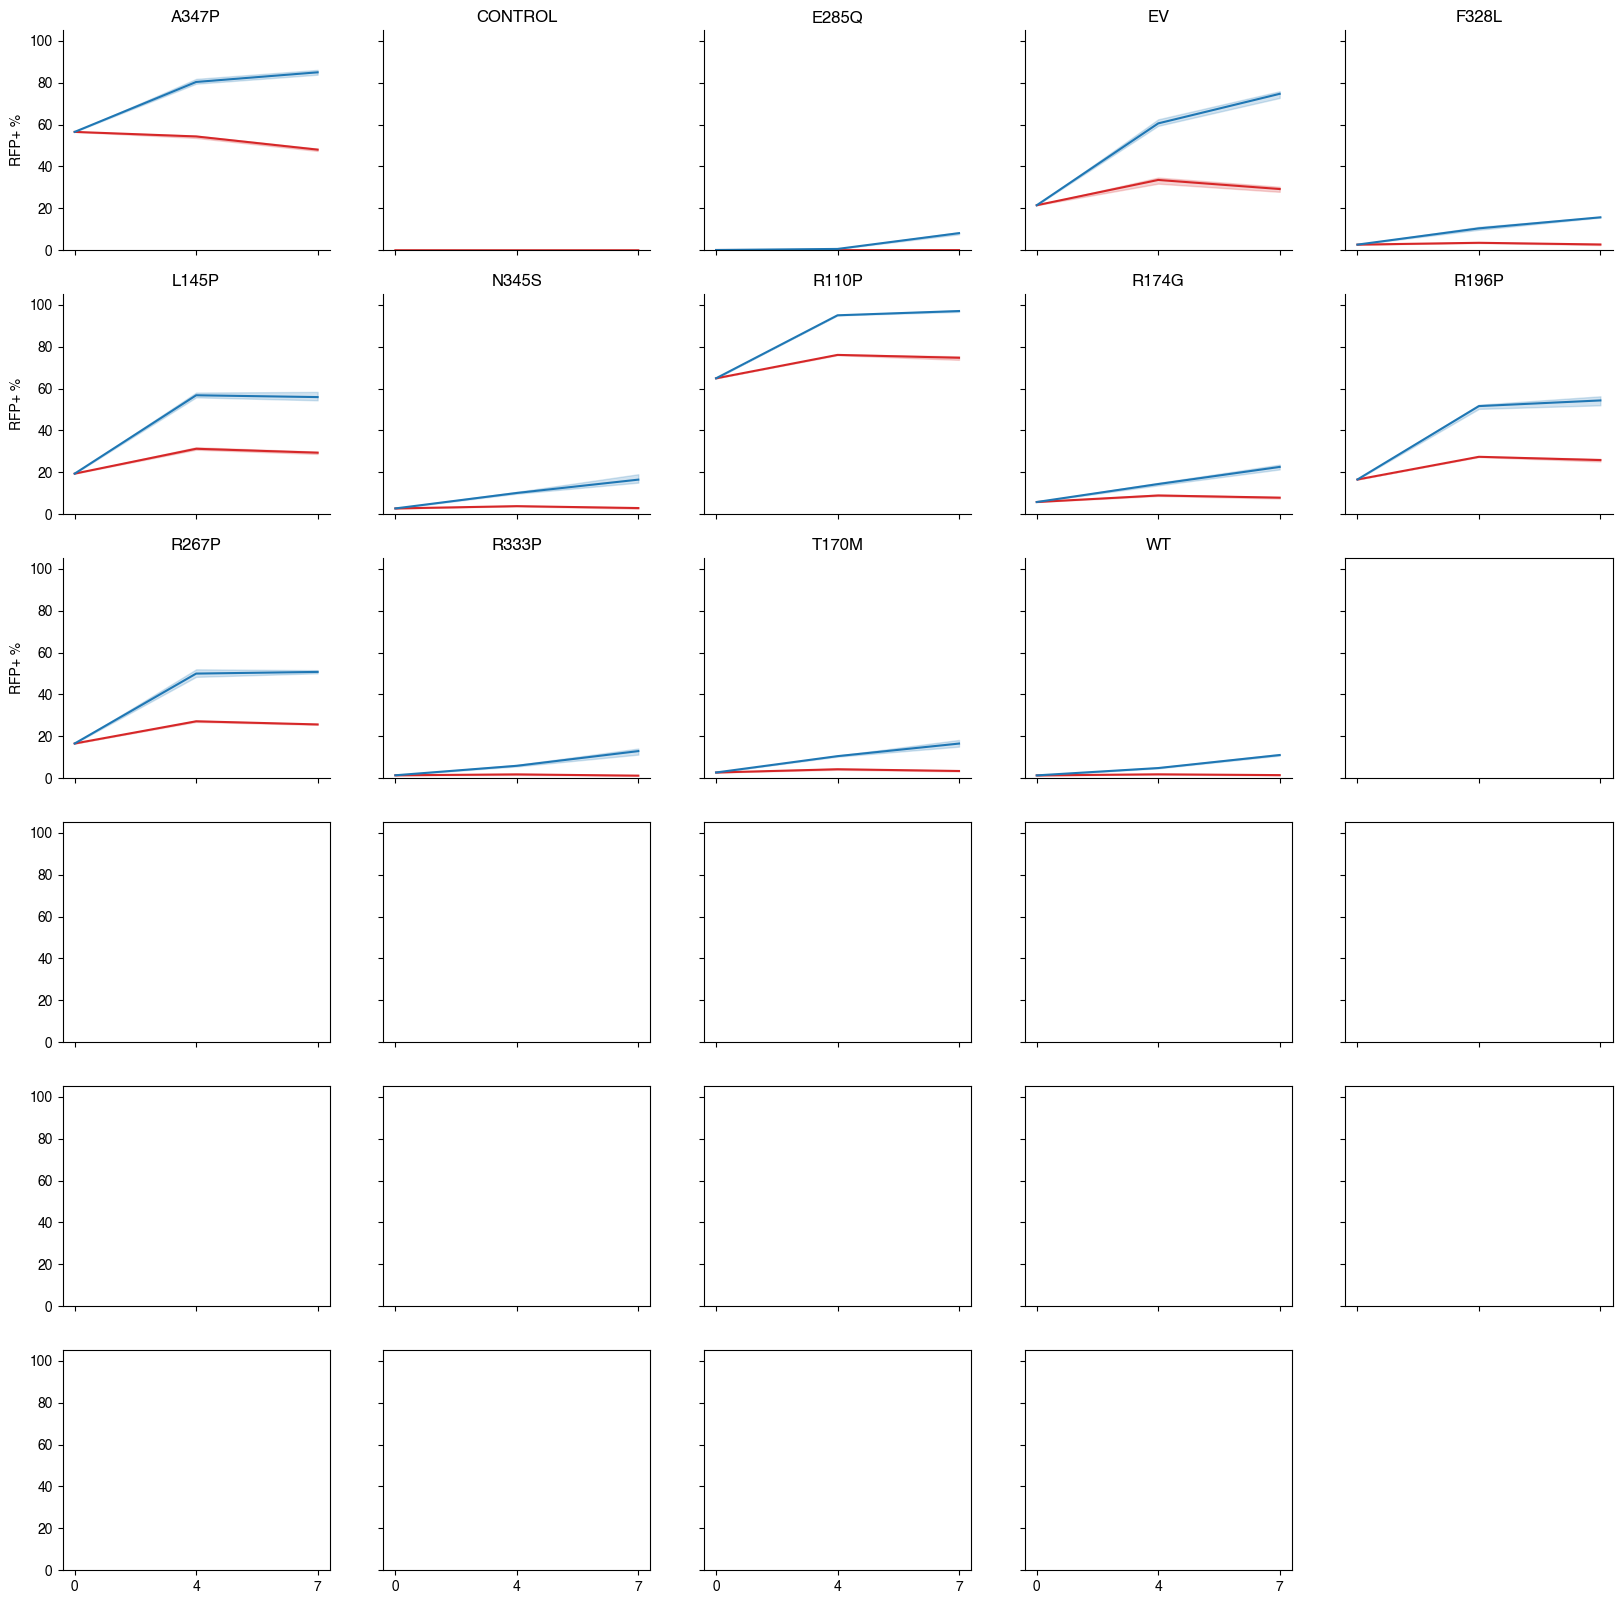

In [441]:
plot_df = cdna

#and plotting
s1 = np.unique(plot_df['cDNA Identity'])
samp_dict = dict(zip(list(range(1, len(s1)+1)), s1))

fig, ax = plt.subplots(6,5, figsize=(20,20), sharex=True, sharey=True)
for i in range(6):
    for k in range(5):
        row = i%6
        col = k
        sample_num = k +1+ i*5 
        if sample_num<=len(s1):
            sns.lineplot(data = plot_df[plot_df['cDNA Identity']==samp_dict[sample_num]], x='Timepoint', y='RFP+ %', hue='Treatment', ax = ax[row][col], legend=False)
            #sns.scatterplot(data = plot_df[plot_df['cDNA Identity']==samp_dict[sample_num]], x='Timepoint', y='RFP+ %', hue='Treatment', style = 'Corrected', markers=['o', 'X'], ax = ax[row][col], legend=False)
            if sample_num<=29:
                tit = samp_dict[sample_num]
                ax[row][col].set_title(tit)
                ax[row][col].spines['top'].set_visible(False)
                ax[row][col].spines['right'].set_visible(False)
                
            else:
                continue
        else:
            continue

ax[0][0].set_xticks([0,1,2])
ax[0][0].set_xticklabels([0,4,7,])
ax[0][0].set_ylim(0,105)
fig.delaxes(ax[5][4])

In [442]:
def event_correction(concat_a549_OD, timepoint_final=2, event_threshold=500):
    """ 
    Function for correction of RFP% when below a certain event threshold;
    If sample is below threshold, this function transforms the dataframe so that 
    the RFP% is equal to that at the previous timepoint
    """
    #event_threshold = 500

    if timepoint_final==1:
        t0 = concat_a549_OD[concat_a549_OD['Timepoint']==0]
        t1 = concat_a549_OD[concat_a549_OD['Timepoint']==1]
        lh = [t1]
    elif timepoint_final==2:
        t0 = concat_a549_OD[concat_a549_OD['Timepoint']==0]
        t1 = concat_a549_OD[concat_a549_OD['Timepoint']==1]
        t2 = concat_a549_OD[concat_a549_OD['Timepoint']==2]
        lh = [t1, t2]
        #t3 = concat_a549_OD[concat_a549_OD['Timepoint']==3]
    elif timepoint_final==3:
        t0 = concat_a549_OD[concat_a549_OD['Timepoint']==0]
        t1 = concat_a549_OD[concat_a549_OD['Timepoint']==1]
        t2 = concat_a549_OD[concat_a549_OD['Timepoint']==2]
        t3 = concat_a549_OD[concat_a549_OD['Timepoint']==3]
        lh = [t1,t2,t3]
    else:
        assert 1==0, print('CORRECT THE FUNCTION TO ACCOUNT FOR DIFFERENT NUMBER OF TIME-POINTS')

    corrected_df = concat_a549_OD.copy()
    corrected_df['Corrected']=False

    #new_dfs = [t0]
    for t, val1 in enumerate(lh):
        x = val1
        x_copy = x.copy()
        timepoint_prev = t
        for i, val in x.iterrows():

            if val['cell_count']< event_threshold:

                v = val['cDNA Identity']
                r = val['Replicate']
                tr = val['Treatment']

                t_previous = corrected_df[corrected_df['Timepoint']==timepoint_prev]

                if timepoint_prev >0:
                    kk =t_previous[(t_previous['cDNA Identity']==v)&(t_previous['Replicate']==r)&(t_previous['Treatment']==tr)]['RFP+ %'].values[0]
                elif timepoint_prev==0:
                    kk =t_previous[(t_previous['cDNA Identity']==v)]['RFP+ %'].values[0]
                
                assert str(x_copy.loc[i, 'cDNA Identity'])==v, print(x_copy.loc[i, 'cDNA Identity'])
                corrected_df.loc[i, 'RFP+ %'] = kk
                corrected_df.loc[i, 'Corrected'] = True
                
            else:
                continue

    return corrected_df


In [446]:
cdna_t0_day7 = cdna[cdna['Timepoint']!=1]
cdna_t0_day7.loc[cdna_t0_day7['Timepoint']==2, 'Timepoint']=1
cdna_t0_day7

,index,Unnamed: 0,cell_count,RFP+ %,Unnamed: 3,Well,cDNA Identity,Treatment,Replicate,Timepoint
84,0,Specimen_001_A1_A01.fcs,10524,0.00950,NaN,A1,CONTROL,Untreated,NaN,1
85,1,Specimen_001_A2_A02.fcs,10335,0.01900,NaN,A2,CONTROL,Untreated,NaN,1
86,2,Specimen_001_A3_A03.fcs,10385,0.00963,NaN,A3,CONTROL,Untreated,NaN,1
87,3,Specimen_001_A7_A07.fcs,11066,1.55000,NaN,A7,WT,Untreated,1.0,1
88,4,Specimen_001_A8_A08.fcs,10332,1.36000,NaN,A8,WT,Untreated,2.0,1
...,...,...,...,...,...,...,...,...,...,...
244,9,NaN,9869,16.60000,NaN,NaN,R267P,Treated,NaN,0
245,10,NaN,9837,1.43000,NaN,NaN,R333P,Treated,NaN,0
246,11,NaN,9822,2.76000,NaN,NaN,T170M,Treated,NaN,0
247,12,NaN,9804,1.38000,NaN,NaN,WT,Treated,NaN,0


In [447]:
corr_d0_d7 = event_correction(cdna_t0_day7, timepoint_final=1, event_threshold=1000)

/Users/samgould/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/samgould/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/samgould/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/samgould/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

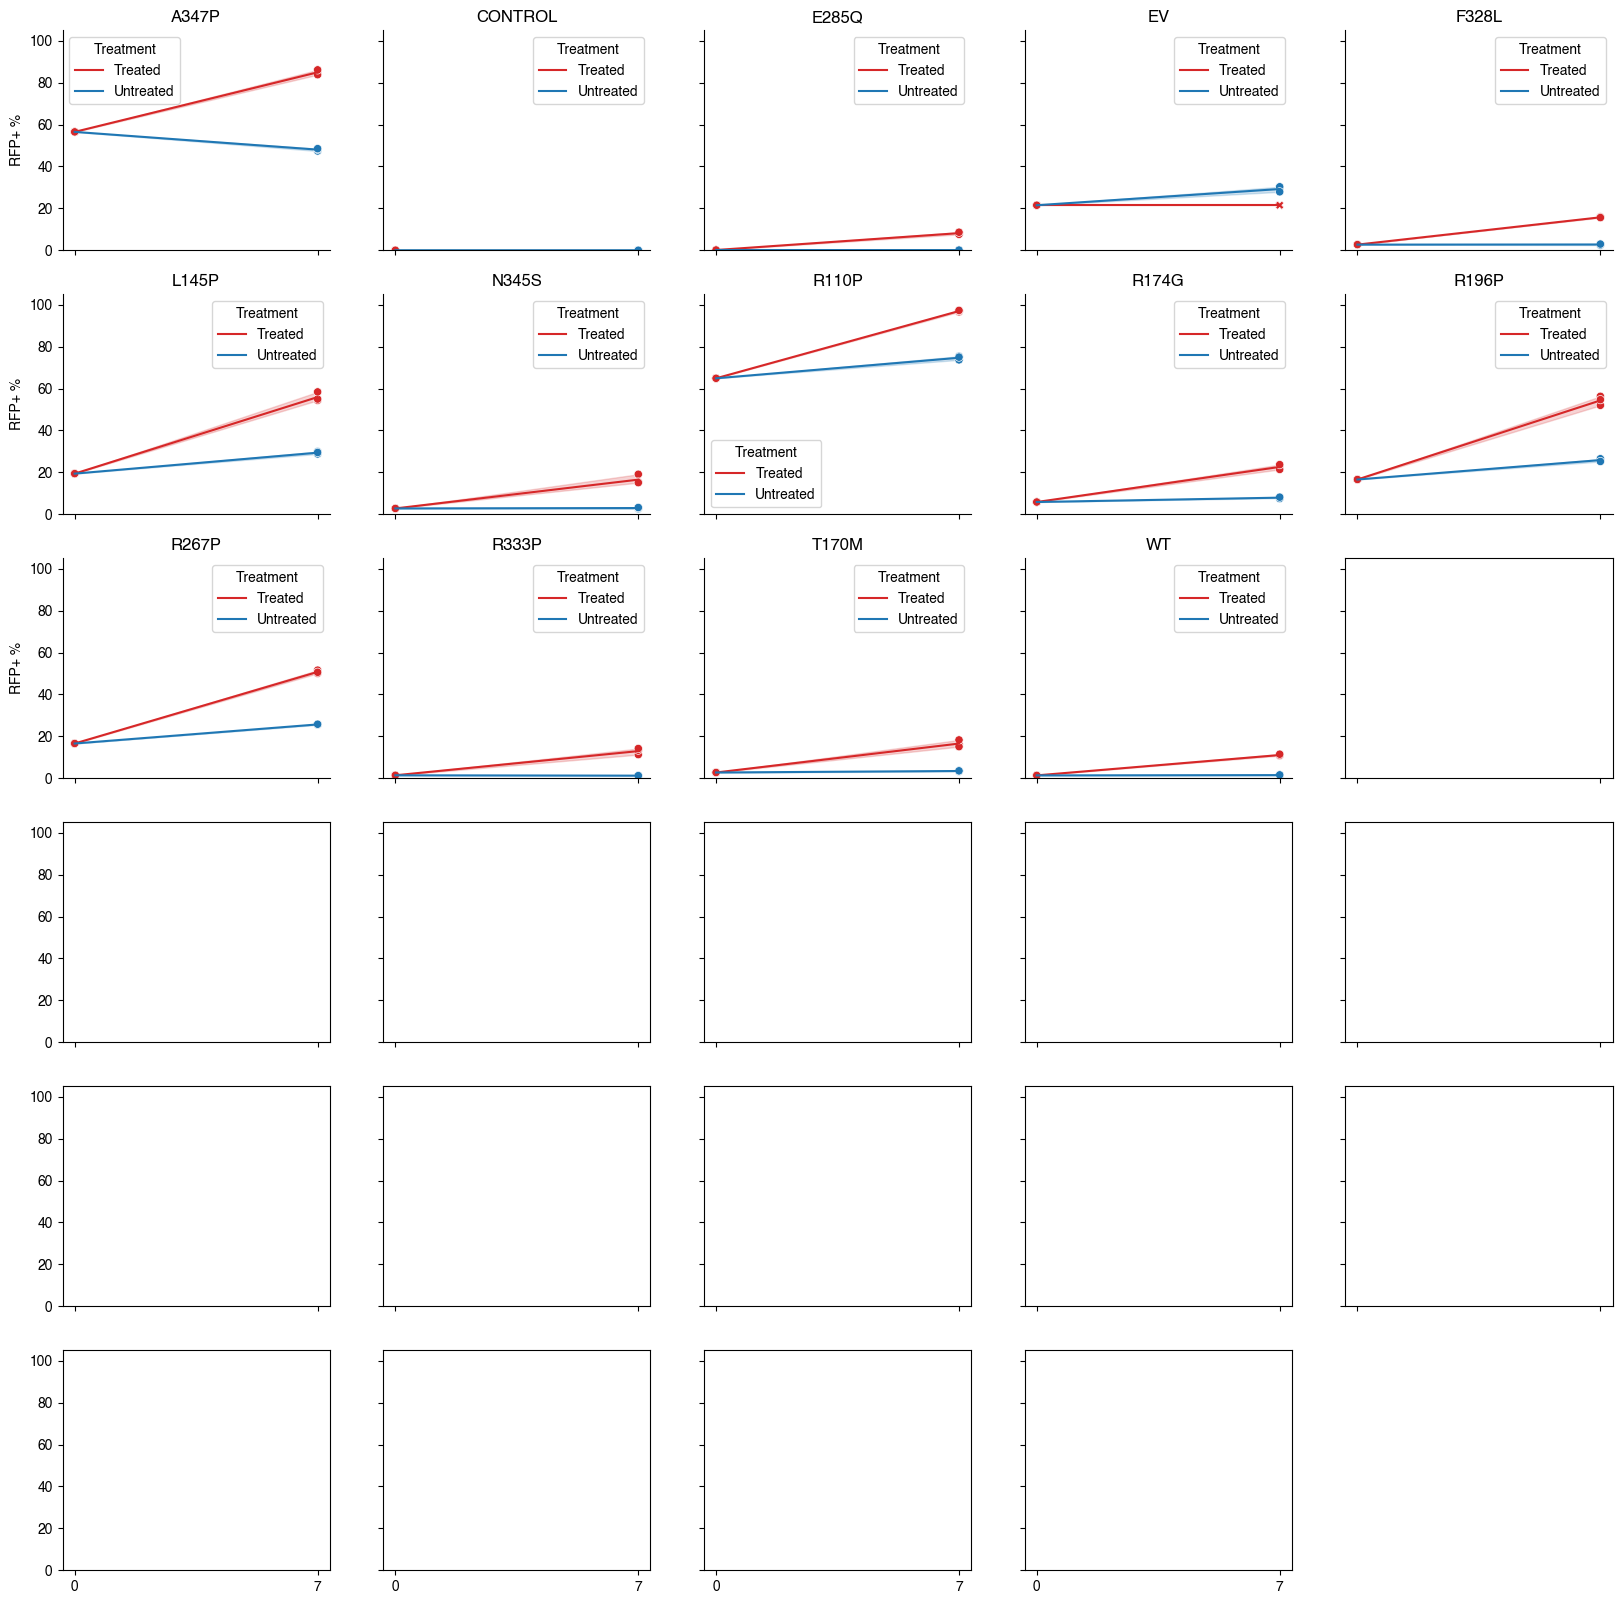

In [460]:
plot_df = corr_d0_d7

#and plotting
s1 = np.unique(plot_df['cDNA Identity'])
samp_dict = dict(zip(list(range(1, len(s1)+1)), s1))
h = ['Treated', 'Untreated']
fig, ax = plt.subplots(6,5, figsize=(20,20), sharex=True, sharey=True)
for i in range(6):
    for k in range(5):
        row = i%6
        col = k
        sample_num = k +1+ i*5 
        if sample_num<=len(s1):
            sns.lineplot(data = plot_df[plot_df['cDNA Identity']==samp_dict[sample_num]], x='Timepoint', y='RFP+ %', hue='Treatment', hue_order = h, ax = ax[row][col], legend=True)
            sns.scatterplot(data = plot_df[plot_df['cDNA Identity']==samp_dict[sample_num]], x='Timepoint', y='RFP+ %', hue='Treatment', hue_order = h,style = 'Corrected', markers=['o', 'X'], ax = ax[row][col], legend=False)
            if sample_num<=29:
                tit = samp_dict[sample_num]
                ax[row][col].set_title(tit)
                ax[row][col].spines['top'].set_visible(False)
                ax[row][col].spines['right'].set_visible(False)
                
            else:
                continue
        else:
            continue

ax[0][0].set_xticks([0,1])
ax[0][0].set_xticklabels([0,7])
ax[0][0].set_ylim(0,105)
fig.delaxes(ax[5][4])

In [448]:
#and lastly, adding information on change in RFP% over time

def fold_change_calc(df, key1 = 'pegRNA Identity', timepoints=2):
    
    hgs = np.unique(df[key1])

    new_dfs = []

    for i in hgs:

        subset = df[df[key1]==i]
        #start with T0
        t0 = subset[subset['Timepoint']==0]['RFP+ %'].values[0]

        subset.loc[subset['Timepoint']==0, 'fold_change']=1
        subset.loc[subset['Timepoint']==0, 'delta_rfp']=0


        #then t1, t2, t3
        
        t1 = subset[subset['Timepoint']==1]['RFP+ %']
        subset.loc[subset['Timepoint']==1, 'fold_change']=t1/t0
        subset.loc[subset['Timepoint']==1, 'delta_rfp']=t1-t0

        if timepoints>=2:
            t2 = subset[subset['Timepoint']==2]['RFP+ %']
            subset.loc[subset['Timepoint']==2, 'fold_change']=t2/t0
            subset.loc[subset['Timepoint']==2, 'delta_rfp']=t2-t0

        if timepoints==3:
            t3 = subset[subset['Timepoint']==3]['RFP+ %']
            subset.loc[subset['Timepoint']==3, 'fold_change']=t3/t0
            subset.loc[subset['Timepoint']==3, 'delta_rfp']=t3-t0


        new_dfs.append(subset)
        
    return pd.concat(new_dfs)

In [451]:
#corr_d0_d7 = event_correction(cdna_t0_day7, timepoint_final=1, event_threshold=1000)

delta_cdna = fold_change_calc(corr_d0_d7, key1 = 'cDNA Identity', timepoints=1)

delta_pegrna = fold_change_calc(a549, key1 = 'pegRNA Identity', timepoints=3)

/var/folders/5g/xxjcy2g531n02hnyb6d8qdsr0000gn/T/ipykernel_91443/2497260451.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.loc[subset['Timepoint']==0, 'fold_change']=1
/var/folders/5g/xxjcy2g531n02hnyb6d8qdsr0000gn/T/ipykernel_91443/2497260451.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.loc[subset['Timepoint']==0, 'delta_rfp']=0
/var/folders/5g/xxjcy2g531n02hnyb6d8qdsr0000gn/T/ipykernel_91443/2497260451.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

/Users/samgould/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/samgould/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/samgould/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<AxesSubplot: xlabel='cDNA Identity', ylabel='delta_rfp'>

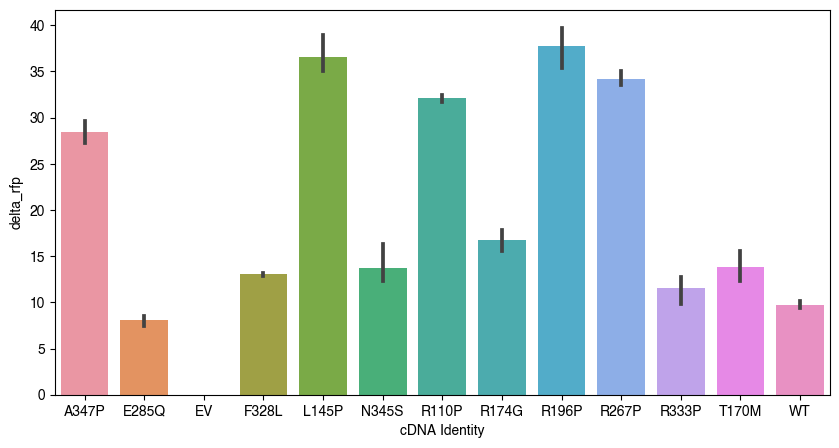

In [452]:
cdna_nut_delta = delta_cdna[(delta_cdna['Timepoint']==1) & (delta_cdna['Treatment']=='Treated')]

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(data=cdna_nut_delta, x='cDNA Identity', y='delta_rfp')

In [453]:
np.unique(cdna_nut_delta['cDNA Identity'])

array(['A347P', 'E285Q', 'EV', 'F328L', 'L145P', 'N345S', 'R110P',
       'R174G', 'R196P', 'R267P', 'R333P', 'T170M', 'WT'], dtype=object)

/Users/samgould/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/samgould/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/samgould/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<AxesSubplot: xlabel='pegRNA Identity', ylabel='delta_rfp'>

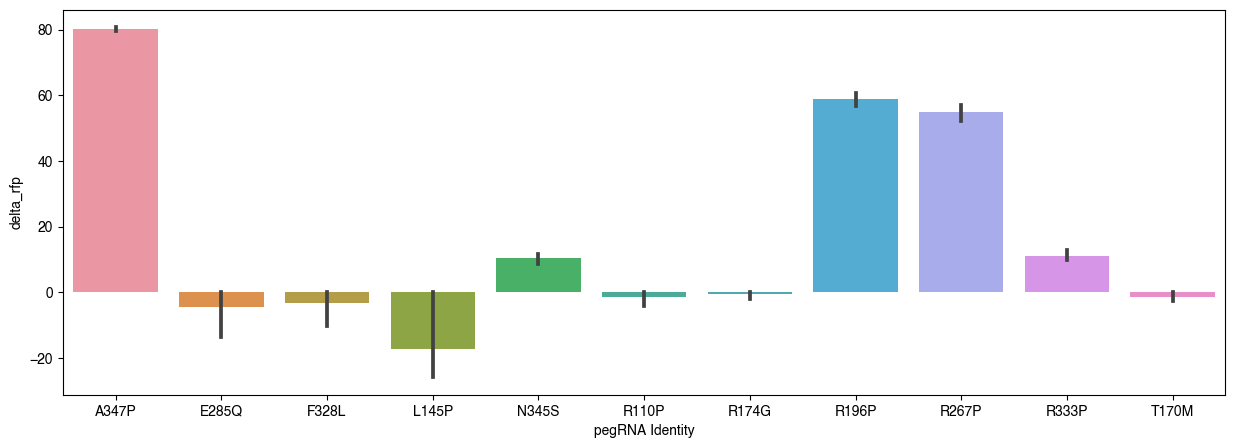

In [454]:
pegrna_nut_delta = delta_pegrna[(delta_pegrna['Timepoint']==1) & (delta_pegrna['Treatment']=='Treated')]
l_mat = ['A347P', 'E285Q', 'F328L', 'L145P', 'N345S', 'R110P',
       'R174G', 'R196P', 'R267P', 'R333P', 'T170M',]
pegrna_nut_delta2 = pegrna_nut_delta[pegrna_nut_delta['pegRNA Identity'].isin(l_mat)]
fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(data=pegrna_nut_delta2, x='pegRNA Identity', y='delta_rfp')

/var/folders/5g/xxjcy2g531n02hnyb6d8qdsr0000gn/T/ipykernel_91443/3249525160.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pegrna_nut_delta2['system'] = 'Prime'
/var/folders/5g/xxjcy2g531n02hnyb6d8qdsr0000gn/T/ipykernel_91443/3249525160.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdna_nut_delta['system'] = 'cDNA'
/Users/samgould/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

<AxesSubplot: xlabel='pegRNA Identity', ylabel='delta_rfp'>

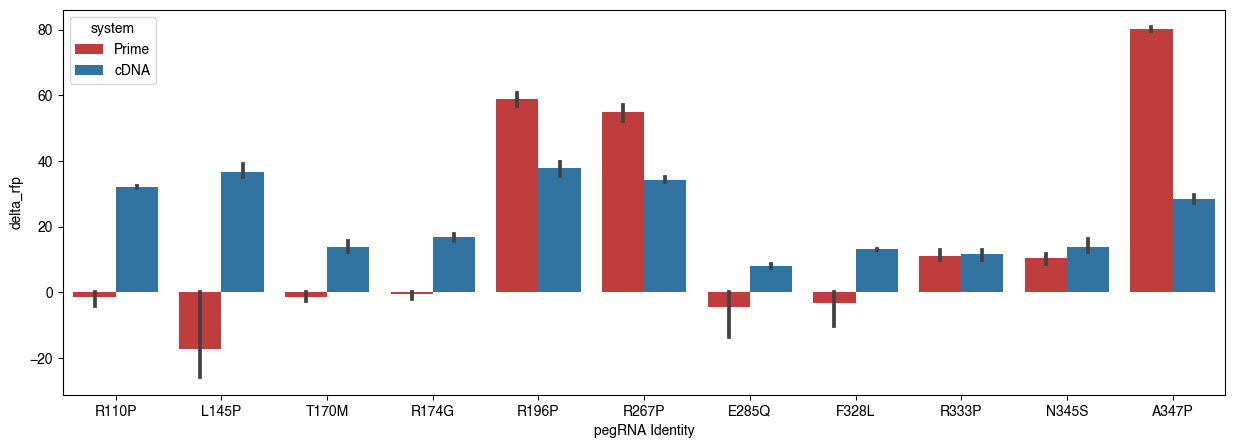

In [455]:
pegrna_nut_delta2 = pegrna_nut_delta[pegrna_nut_delta['pegRNA Identity'].isin(l_mat)]

pegrna_nut_delta2['system'] = 'Prime'
cdna_nut_delta['system'] = 'cDNA'
cdna_nut_delta = cdna_nut_delta.rename(columns = {'cDNA Identity': 'pegRNA Identity'})

combined_peg_cdna = pd.concat((pegrna_nut_delta2, cdna_nut_delta))

fig, ax = plt.subplots(figsize=(15,5))



order = ['R110P','L145P', 'T170M','R174G', 'R196P','R267P','E285Q','F328L','R333P','N345S', 'A347P',]

sns.barplot(data=combined_peg_cdna , x='pegRNA Identity', y='delta_rfp', hue='system', order=order)

In [456]:
control_pegs = pegrna_nut_delta[~pegrna_nut_delta['pegRNA Identity'].isin(l_mat)]
controls = list(np.unique(control_pegs['pegRNA Identity']))

In [457]:
noncont = list(np.unique(pegrna_nut_delta2['pegRNA Identity']))
d_cont = dict(zip(controls, noncont))

/var/folders/5g/xxjcy2g531n02hnyb6d8qdsr0000gn/T/ipykernel_91443/3449917453.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_pegs['system'] = 'Matched control pegRNA'
/var/folders/5g/xxjcy2g531n02hnyb6d8qdsr0000gn/T/ipykernel_91443/3449917453.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_pegs['pegRNA Identity'] = [d_cont[i] for i in control_pegs['pegRNA Identity']]
/Users/samgould/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype

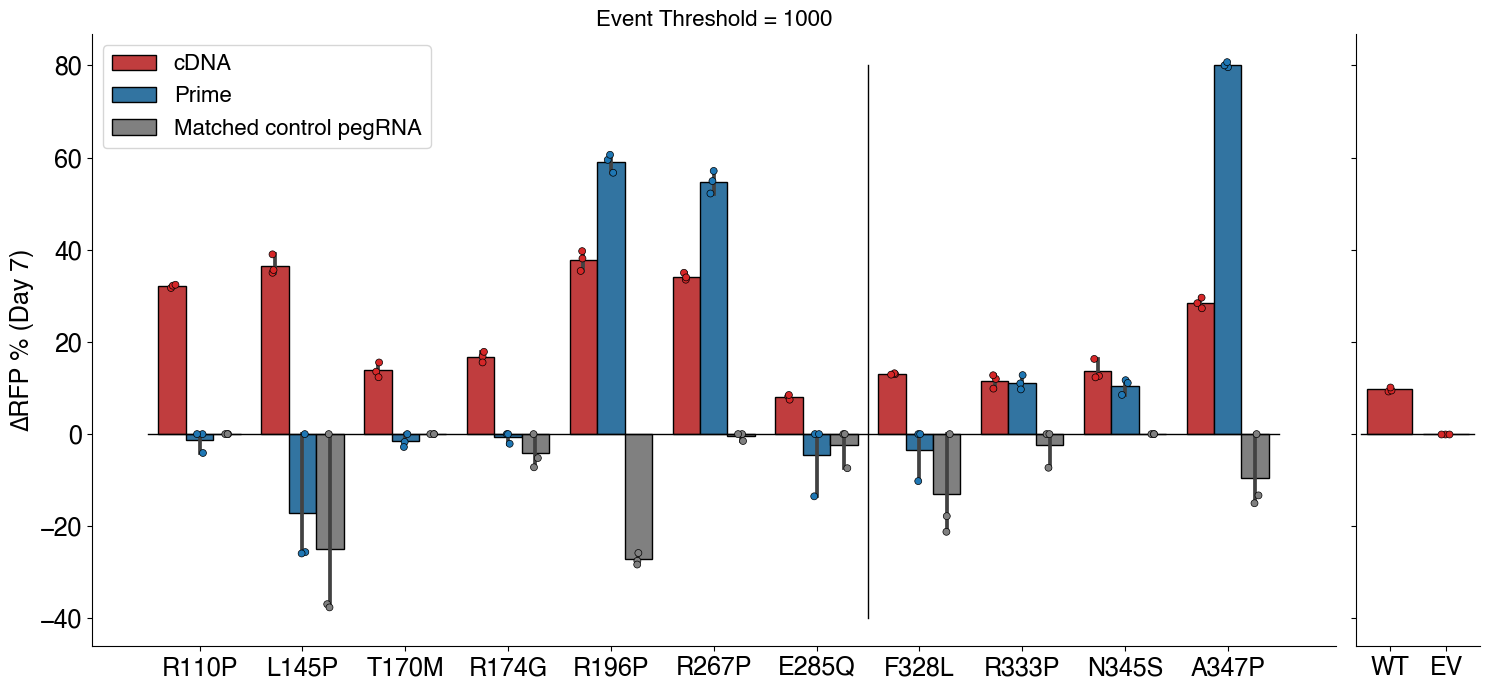

In [458]:
control_pegs = pegrna_nut_delta[~pegrna_nut_delta['pegRNA Identity'].isin(l_mat)]
control_pegs['system'] = 'Matched control pegRNA'

control_pegs['pegRNA Identity'] = [d_cont[i] for i in control_pegs['pegRNA Identity']]

a345 = pd.concat((combined_peg_cdna, control_pegs)).reset_index()
order = ['R110P','L145P', 'T170M','R174G', 'R196P','R267P','E285Q','F328L','R333P','N345S', 'A347P',]

colors = ["tab:red", "tab:blue", "grey"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

hue_order=['cDNA','Prime', 'Matched control pegRNA']

fig, ax = plt.subplots(1,2, figsize=(15,7), width_ratios=[10,1], sharey=True)
sns.barplot(data=a345 , x='pegRNA Identity', y='delta_rfp', hue='system', hue_order=hue_order, order=order, linewidth=1, edgecolor='black', ax=ax[0])
sns.stripplot(data=a345 , x='pegRNA Identity', y='delta_rfp', hue='system', hue_order=hue_order,order=order, dodge=True, linewidth=.5, edgecolor='black', legend=False, ax=ax[0])
order2 = ['WT', 'EV']
sns.barplot(data=a345 , x='pegRNA Identity', y='delta_rfp',color='tab:red', order=order2, linewidth=1, edgecolor='black', ax=ax[1])
sns.stripplot(data=a345 , x='pegRNA Identity', y='delta_rfp', color='tab:red',order=order2, dodge=True, linewidth=.5, edgecolor='black', legend=False, ax=ax[1])
ax[0].tick_params(axis='both', which='major', labelsize=18)
ax[1].tick_params(axis='both', which='major', labelsize=18)
ax[0].spines[['top', 'right']].set_visible(False)
ax[1].spines[['top', 'right']].set_visible(False)

ax[0].set_ylabel('∆RFP % (Day 7)', fontsize=18)
ax[1].set_ylabel('', fontsize=18)
ax[0].set_xlabel('')
ax[1].set_xlabel('')

ax[0].plot([0-.5,10+.5], [0,0], color='black', linewidth=1)
ax[1].plot([0-.5,1+.5], [0,0], color='black', linewidth=1)
ax[0].plot([6.5,6.5], [-40,80], color='black', linewidth=1)

ax[0].legend(fontsize=16)
ax[0].set_title('Event Threshold = 1000', fontsize=16)
fig.tight_layout()
#fig.savefig('fig6_1000.pdf')

In [405]:
peg2 = pegrna_nut_delta2[['pegRNA Identity', 'delta_rfp']].groupby(by='pegRNA Identity').mean().reset_index()
#peg2['system'] = 'pegRNA'
peg2 = peg2.rename(columns = {'delta_rfp':'delta_rfp_pegRNA'})
peg2

,pegRNA Identity,delta_rfp_pegRNA
0,A347P,80.100000
1,E285Q,-15.533333
2,F328L,-10.533333
3,L145P,-25.966667
4,N345S,10.433333
5,R110P,-3.566667
6,R174G,-1.333333
7,R196P,58.933333
8,R267P,54.733333
9,R333P,11.166667


In [406]:
cdna2 = cdna_nut_delta[['pegRNA Identity', 'delta_rfp']].groupby(by='pegRNA Identity').mean().reset_index()
cdna2= cdna2.rename(columns = {'delta_rfp':'delta_rfp_cDNA'})
merged_prime_cdna = pd.merge(peg2, cdna2, on='pegRNA Identity')
merged_prime_cdna

,pegRNA Identity,delta_rfp_pegRNA,delta_rfp_cDNA
0,A347P,80.100000,28.433333
1,E285Q,-15.533333,8.050000
2,F328L,-10.533333,13.033333
3,L145P,-25.966667,36.533333
4,N345S,10.433333,13.743333
5,R110P,-3.566667,32.100000
6,R174G,-1.333333,16.750000
7,R196P,58.933333,37.733333
8,R267P,54.733333,34.166667
9,R333P,11.166667,11.536667


In [407]:
scipy.stats.pearsonr(merged_prime_cdna['delta_rfp_pegRNA'], merged_prime_cdna['delta_rfp_cDNA'])

PearsonRResult(statistic=0.44997079862905703, pvalue=0.16492678783290496)

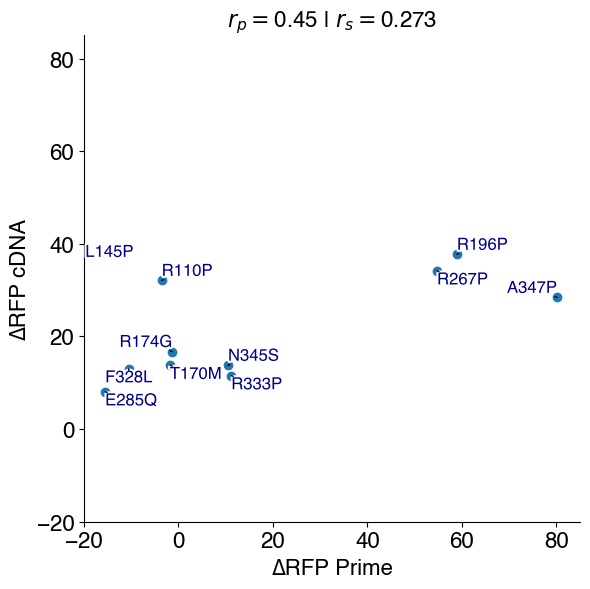

In [408]:
fig, ax= plt.subplots(figsize=(6,6))
ax.scatter(merged_prime_cdna['delta_rfp_pegRNA'], merged_prime_cdna['delta_rfp_cDNA'])
ax.set_xlim(-20,85)
ax.set_ylim(-20,85)
ax.set_xlabel('∆RFP Prime', fontsize=16)
ax.set_ylabel('∆RFP cDNA', fontsize=16)

spear = np.round(scipy.stats.spearmanr(merged_prime_cdna['delta_rfp_pegRNA'], merged_prime_cdna['delta_rfp_cDNA']).statistic, 3)
pear = np.round(scipy.stats.pearsonr(merged_prime_cdna['delta_rfp_pegRNA'], merged_prime_cdna['delta_rfp_cDNA']).statistic, 3)

ax.set_title('$r_{p}=$' +  f'{pear} | ' + '$r_{s}=$' + f'{spear}', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


t = list(merged_prime_cdna['pegRNA Identity'])
x=list(merged_prime_cdna['delta_rfp_pegRNA'])
y = list(merged_prime_cdna['delta_rfp_cDNA'])


texts = [ax.text(x[i], y[i], t[i], fontsize=12, color='darkblue', path_effects=[PathEffects.withStroke(linewidth=3,
                                                                                  foreground="w")]) for i in range(len(x))] #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = .9)


adjust_text(texts,only_move={'points':'y', 'texts':'xy'},
            arrowprops=dict(arrowstyle="-", linewidth=1, alpha=1, color='black'))


fig.tight_layout()

In [230]:
b = pd.read_excel('existing_p53_variant_annotations/41588_2018_204_MOESM6_ESM.xlsx', header=1) #z-scores

b = b.rename(columns={'Allele':'pegRNA Identity'})
wt_nut = 'A549_p53WT_Nutlin-3_Z-score'

giacomelli_data = b[['pegRNA Identity', wt_nut]]

In [235]:
g = giacomelli_data[giacomelli_data['pegRNA Identity'].isin(order)]
merged_prime_cdna_g = pd.merge(g, merged_prime_cdna, on='pegRNA Identity')
merged_prime_cdna_g

,pegRNA Identity,A549_p53WT_Nutlin-3_Z-score,delta_rfp_pegRNA,delta_rfp_cDNA
0,R110P,1.085446,-1.366667,32.100000
1,L145P,1.580916,-17.166667,36.533333
2,T170M,0.108130,-1.500000,13.806667
3,R174G,0.576431,-0.700000,16.750000
4,R196P,1.579776,58.933333,37.733333
5,R267P,1.699425,54.733333,34.166667
6,E285Q,0.211332,-4.500000,8.050000
7,F328L,-0.346109,-3.400000,13.033333
8,R333P,-1.919722,11.166667,11.536667
9,N345S,-0.940095,10.433333,13.743333


In [253]:
giacomelli_data[giacomelli_data['pegRNA Identity']=='T170T']

,pegRNA Identity,A549_p53WT_Nutlin-3_Z-score


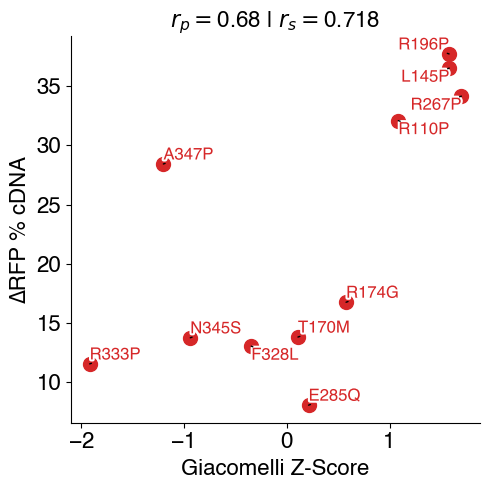

In [411]:
fig, ax= plt.subplots(figsize=(5,5))

ax.scatter(merged_prime_cdna_g[wt_nut], merged_prime_cdna_g['delta_rfp_cDNA'], s=100,c='tab:red')
#ax.set_xlim(-20,85)
#ax.set_ylim(-20,85)

spear = np.round(scipy.stats.spearmanr(merged_prime_cdna_g[wt_nut], merged_prime_cdna_g['delta_rfp_cDNA']).statistic, 3)
pear = np.round(scipy.stats.pearsonr(merged_prime_cdna_g[wt_nut], merged_prime_cdna_g['delta_rfp_cDNA']).statistic, 3)

ax.set_xlabel('Giacomelli Z-Score', fontsize=16)
ax.set_ylabel('∆RFP % cDNA', fontsize=16)
ax.set_title('$r_{p}=$' +  f'{pear} | ' + '$r_{s}=$' + f'{spear}', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


t = list(merged_prime_cdna_g['pegRNA Identity'])
x=list(merged_prime_cdna_g[wt_nut])
y = list(merged_prime_cdna_g['delta_rfp_cDNA'])


texts = [ax.text(x[i], y[i], t[i], fontsize=12, color='tab:red', path_effects=[PathEffects.withStroke(linewidth=3,
                                                                                  foreground="w")]) for i in range(len(x))] #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = .9)


adjust_text(texts,only_move={'points':'y', 'texts':'xy'},
            arrowprops=dict(arrowstyle="-", linewidth=1, alpha=1, color='black'))


fig.tight_layout()

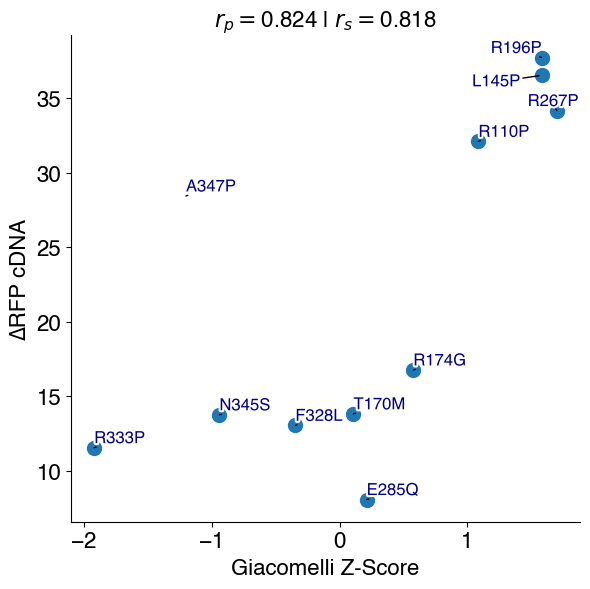

In [389]:
fig, ax= plt.subplots(figsize=(6,6))

merged_prime_cdna_g2 = merged_prime_cdna_g[merged_prime_cdna_g['pegRNA Identity']!='A347P']
ax.scatter(merged_prime_cdna_g2[wt_nut], merged_prime_cdna_g2['delta_rfp_cDNA'], s=100)
#ax.set_xlim(-20,85)
#ax.set_ylim(-20,85)

spear = np.round(scipy.stats.spearmanr(merged_prime_cdna_g2[wt_nut], merged_prime_cdna_g2['delta_rfp_cDNA']).statistic, 3)
pear = np.round(scipy.stats.pearsonr(merged_prime_cdna_g2[wt_nut], merged_prime_cdna_g2['delta_rfp_cDNA']).statistic, 3)

ax.set_xlabel('Giacomelli Z-Score', fontsize=16)
ax.set_ylabel('∆RFP cDNA', fontsize=16)
ax.set_title('$r_{p}=$' +  f'{pear} | ' + '$r_{s}=$' + f'{spear}', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


t = list(merged_prime_cdna_g['pegRNA Identity'])
x=list(merged_prime_cdna_g[wt_nut])
y = list(merged_prime_cdna_g['delta_rfp_cDNA'])


texts = [ax.text(x[i], y[i], t[i], fontsize=12, color='darkblue', path_effects=[PathEffects.withStroke(linewidth=3,
                                                                                  foreground="w")]) for i in range(len(x))] #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = .9)


adjust_text(texts,only_move={'points':'y', 'texts':'xy'},
            arrowprops=dict(arrowstyle="-", linewidth=1, alpha=1, color='black'))


fig.tight_layout()

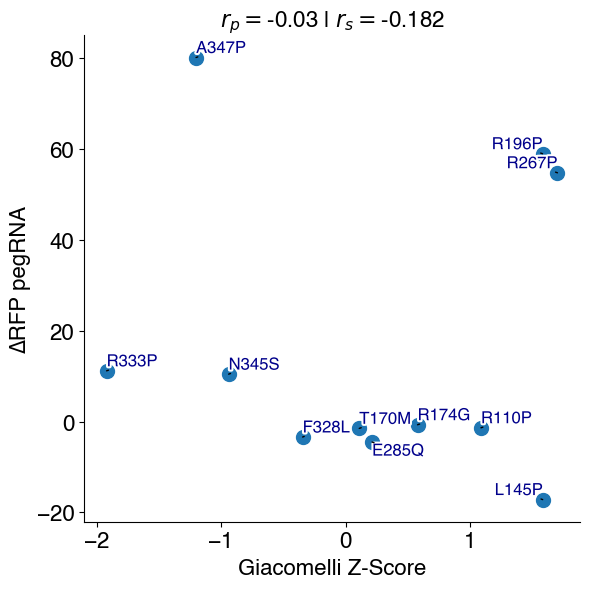

In [256]:
fig, ax= plt.subplots(figsize=(6,6))
ax.scatter(merged_prime_cdna_g[wt_nut], merged_prime_cdna_g['delta_rfp_pegRNA'], s=100)
#ax.set_xlim(-20,85)
#ax.set_ylim(-20,85)

spear = np.round(scipy.stats.spearmanr(merged_prime_cdna_g[wt_nut], merged_prime_cdna_g['delta_rfp_pegRNA']).statistic, 3)
pear = np.round(scipy.stats.pearsonr(merged_prime_cdna_g[wt_nut], merged_prime_cdna_g['delta_rfp_pegRNA']).statistic, 3)

ax.set_xlabel('Giacomelli Z-Score', fontsize=16)
ax.set_ylabel('∆RFP pegRNA', fontsize=16)
ax.set_title('$r_{p}=$' +  f'{pear} | ' + '$r_{s}=$' + f'{spear}', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


t = list(merged_prime_cdna_g['pegRNA Identity'])
x=list(merged_prime_cdna_g[wt_nut])
y = list(merged_prime_cdna_g['delta_rfp_pegRNA'])


texts = [ax.text(x[i], y[i], t[i], fontsize=12, color='darkblue', path_effects=[PathEffects.withStroke(linewidth=3,
                                                                                  foreground="w")]) for i in range(len(x))] #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = .9)


adjust_text(texts,only_move={'points':'y', 'texts':'xy'},
            arrowprops=dict(arrowstyle="-", linewidth=1, alpha=1, color='black'))


fig.tight_layout()

In [242]:
scipy.stats.spearmanr(merged_prime_cdna_g[wt_nut], merged_prime_cdna_g['delta_rfp_cDNA'])

SignificanceResult(statistic=0.7181818181818183, pvalue=0.01279959806885844)

In [243]:
scipy.stats.pearsonr(merged_prime_cdna_g[wt_nut], merged_prime_cdna_g['delta_rfp_cDNA'])

PearsonRResult(statistic=0.680087700611932, pvalue=0.021297975096374842)

In [240]:
g = giacomelli_data[giacomelli_data['pegRNA Identity'].isin(order)]
g['system'] = 'Giacomelli et al.'
g

/var/folders/5g/xxjcy2g531n02hnyb6d8qdsr0000gn/T/ipykernel_91443/2882703426.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g['system'] = 'Giacomelli et al.'


,pegRNA Identity,A549_p53WT_Nutlin-3_Z-score,system
2295,R110P,1.085446,Giacomelli et al.
3028,L145P,1.580916,Giacomelli et al.
3549,T170M,0.108130,Giacomelli et al.
3628,R174G,0.576431,Giacomelli et al.
4097,R196P,1.579776,Giacomelli et al.
5585,R267P,1.699425,Giacomelli et al.
5963,E285Q,0.211332,Giacomelli et al.
6862,F328L,-0.346109,Giacomelli et al.
6971,R333P,-1.919722,Giacomelli et al.
7224,N345S,-0.940095,Giacomelli et al.
